# Lab 6

### Wyszukiwarka

In [3]:
import json
import numpy as np
import pickle as pkl
import wikipediaapi as wpa
from urllib.error import HTTPError
import re
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from bs4 import BeautifulSoup as bs
from urllib.request import urlopen
from urllib.parse import quote
from scipy.sparse import csr_matrix
from scipy.sparse.linalg import svds
from time import perf_counter

### Klasa pobierająca wybrane artykuły z wikipedii

Pobieranie artykułów z wikipedii na podstawie biblioteki wikiepedia-api
Biblioteka pobiera artykuly na podstawie podanej kategorii

Następnie po pobraniu wybranej ilości tworzony jest słownik wyrazów gdy wyrazów, gdy dane słowo znajduje sie w artykule oraz
słownik wyrazów dla kazdej poszczególnej strony.
Te dane są zapisywane do odpowiednich plików za pomocą pickle 

In [3]:
class WikipediaPage():
    def __init__(self,max_articles_per_category=100):
        self.sites = set()
        self.wiki = wpa.Wikipedia('en')
        self.words = dict()
        self.dicts = []
        self.site_list = []
        self.wnl = WordNetLemmatizer()
        self.stop_words = set(stopwords.words('english'))
        self.max_articles_per_category = max_articles_per_category

    def crawl(self,categorymembers,max_articles,level=0, max_level=1):
        for c in categorymembers.values():
            if c.ns == wpa.Namespace.CATEGORY and level < max_level and len(self.sites) <= max_articles:
                self.crawl(c.categorymembers,max_articles ,level=level + 1, max_level=max_level)
            elif c.ns == wpa.Namespace.MAIN:
                if len(self.sites) <= max_articles:
                    self.sites.add(c)
    def get_words(self,sites):
        for site in sites:
            
            # link = site
            # if we sent there full links we can use the above line
            link = self.get_links(site)
            try:
                # start = perf_counter()
                webpage = str(urlopen(link).read())
                soup = bs(webpage, features="html.parser")
                content = self.filter_out(soup.get_text())
                self.dicts.append(dict())
                word_list = content.split()
                lemmatized = [self.wnl.lemmatize("".join(filter(lambda x: x.isalpha(), word))
                                        ).casefold() for word in word_list]
                # filter out words with length less than 3
                filtered = list(filter(lambda x: len(x) > 2, lemmatized))
                # filter out words that are in stop words
                filtered = list(filter(lambda x: x not in self.stop_words, filtered))
         
                for s in filtered:
                    dicts_element_count = self.dicts[-1].get(s, 0)
                    if dicts_element_count == 0:
                        self.words[s] = self.words.get(s, 0) + 1
                    self.dicts[-1][s] = dicts_element_count + 1
                        
                # end = perf_counter()
                # print(f"Time taken for {site.title} is {end-start}")
            except HTTPError:
                print("HTTPError")
                pass
            except Exception as e:
                print(f"Different Error: , {e}")
                pass

    def get_wiki_data(self,i):
        categories = ["Physics","Music","Games","Mathematics", "Medicine", "Chemistry", "Biology", "Astronomy", "History", "Geography", \
                      "Art", "Literature", "Philosophy", "Religion", "Mythology", "Politics", "Law", "Economics", "Psychology", "Sociology", \
                        "Education", "Technology", "Engineering", "Transport", "Food", "Drink", "Health", "Fashion", "Media", "Entertainment", \
                            "Sports", "Military", "Travel", "Business", "Finance", "Industry", "Agriculture", "Language", "Communication", \
                                "Architecture", "Infrastructure", "Environment", "Nature", "Disasters", "Energy", "Space", "Time", "Measurement", \
                                    "Numbers", "Money", "Units", "People", "Organizations", "Animals", "Plants", "Materials", "Computing", \
                                        "Internet", "Software", "Hardware", "Programming", "Data", "Fiction", "Chemicals"]
        print("Downloading categories started")
        count = 0
        for c in categories:
            count += 1
            print(c)
            wiki_name = "Category:" + c
            cat = self.wiki.page(wiki_name)
            self.crawl(cat.categorymembers,self.max_articles_per_category * count, max_level=1)
            if len(self.sites) > i:
                break
        self.site_list = list(self.sites)[:i]
        titles = [site.title for site in self.site_list]
        with open("content/titles.pkl", "wb") as write_file:
            pkl.dump(titles, write_file)
        
        print("Downloading categories finished")
        # alternatively we can send the links to the get_words function
        # self.get_words([site.fullurl for site in self.sites])
        self.get_words(titles)
        print("Downloading sites finished")
        return self.words,self.dicts
    def filter_out(self,text):
        # get rid of all special characters
        partly = re.sub('\\\\t|\\\\n|\\\\r|\\\\a|\\\\f|\\\\v|\\\\b', " ", text)
        # get rid of all special ascii characters
        partly = re.sub('\\\\x[0-9a-fA-F]{2}', " ", partly)
        partly = re.sub('[^A-Za-z]+', ' ', partly)
        return partly
    def get_links(self,title):
        return "https://en.wikipedia.org/wiki/"+quote(title.replace(" ", "_"))

Nalezy równiez pobrać odpowiednie rzeczy z biblioteki nltk aby pobieranie działało. 

In [ ]:
# nltk.download("punkt")
# nltk.download('stopwords')
# nltk.download("wordnet")
# nltk.download("omw-1.4")

### Klasa Matrix

Klasa ta pobiera wszystkie bag-of-words (musimy sobie je pobrać z plików)

Początkowo tworzy ona zwykłą macerz wektorów cech term-by-document
Następnie przetwarza macierz za pomocą IDF (inverse-document-frequency) wykorzystuje ona słowa, które równiez mamy zapisane z poprzedniej klasy.

Normalizuje wektory z macierzy cech

Następnie przekształca macierz numpy na macierz scipy za pomocą csr_matrix

Na koniec przekształca tę macierz za pomoca svds z biblioteki scipy, tj. sparse.linalg


In [4]:
class Matrix():
    def __init__(self,words=None,sites_words=None,n=None):
        self.n = n
        self.words = words
        self.dicts = sites_words

    def get_matrix(self):
        self.keys = list(self.words.keys())
        self.number_of_words = len(self.keys)
        self.matrix = np.zeros((self.n, self.number_of_words))
        self.index = {i: self.keys[i] for i in range(self.number_of_words)}
        self.reverse_index = {self.keys[i]: i for i in range(self.number_of_words)}
        #Iterate through sites
        for i in range(self.n):
            #Iterate through words
            for word in self.dicts[i]:
                self.matrix[i,self.reverse_index[word]] = self.dicts[i][word]
        print("frequency normalization started")
        #It's inverse document frequency
        m = np.log10(np.array([n / sum(1 for article in self.dicts if self.keys[i] in article) for i in range(self.number_of_words)]))
        self.matrix = self.matrix * m

        #Here starts normalization of vectors
        lengths = np.nan_to_num(1 / np.sqrt(np.sum(self.matrix ** 2, axis=1)), False, nan=0.0, posinf=0.0, neginf=0.0)
        self.matrix = (self.matrix.T * lengths).T
        self.length = np.sqrt(np.sum(self.matrix ** 2, axis=1))
        print("frequency normalization finished")

        #Lower approximation
        print("starting lower approximation")
        self.matrix = csr_matrix(self.matrix)
        start = perf_counter()
        self.U, self.D, self.V = svds(self.matrix, k=100)
        # U, D, V = np.linalg.svd(self.matrix)
        end = perf_counter()
        print(f"lower approximation finished in {end - start:0.4f} seconds")
        # r = len(self.D)
        # print("calculating matrix")
        # self.matrix = self.U[:, :r] @ np.diag(self.D) @ self.V[:r, :]
        # print(f"matrix shape: {self.matrix.shape}")
        print("matrix created")

    def save(self):
        # with open("content/matrix.pkl", "wb") as write_file:
        #     pkl.dump(self.matrix, write_file)
        with open("content/dict.pkl", "wb") as write_file:
            pkl.dump(self.index, write_file)
        with open("content/U.pkl", "wb") as write_file:
            pkl.dump(self.U, write_file)
        with open("content/D.pkl", "wb") as write_file:
            pkl.dump(self.D, write_file)
        with open("content/V.pkl", "wb") as write_file:
            pkl.dump(self.V, write_file)
        with open("content/length.pkl", "wb") as write_file:
            pkl.dump(self.length, write_file)

Stwierdziłem, ze lepiej bedzie jak zapisze bezpośrednio wszystkie 3 macierze z svds (U, D, V), zamiast odrazu wyliczać tą większą macierz to podczas wyszukiwania przemnazam wszystkie 3 macierze razem z wektorem, nie zmienia to praktycznie prędkości działania programu, a zyskuje mocno na zaoszczędzonej pamięci i czasie tworzenia duzej macierzy w tym przypadku matrix.pkl

Przykładowe wywołanie funkcji wyszukującej artykuły:

n - ilość artykułów

per_category - ilosc artykułow na kazda kategorie uwzglednioną w klasie WikipediaPage

In [ ]:
n = 100
per_category = 100
Wiki = WikipediaPage(per_category)
words_data, sites_data = Wiki.get_wiki_data(n)

Zapisanie do pliku tych danych

In [5]:
# If you want to write
with open("content/words_data.pkl", "wb") as write_file:
    pkl.dump(words_data, write_file)
with open("content/sites_data.pkl", "wb") as write_file:
    pkl.dump(sites_data, write_file)


Wczytanie ich ponownie

In [ ]:

with open("content/words_data.pkl", "rb") as read_file:
    words_data = pkl.load(read_file)
with open("content/sites_data.pkl", "rb") as read_file:
    sites_data = pkl.load(read_file)

Przykładowe wywołanie klasy Matrix

In [ ]:
n = 100
matrix = Matrix(words_data,sites_data,n)
matrix.get_matrix()
matrix.save()

Na koniec nalezy włączyc program search.py podajac 2 argumenty: nazwa wyszukiwana oraz ilosc artykułów, np:

python3 search.py math 5

Wyświetli nam jsona który zawiera wszystkie artykuły z najlepszym prawdopodobienstwem posortowane malejące według tej wartości 

Ponizej wrzucam kod tego pliku:


In [ ]:
import sys
import spacy
import warnings
warnings.filterwarnings("ignore")


def search(top,text):
    wnl = WordNetLemmatizer()
    with open("content/titles.pkl", "rb") as read_file:
        sites = pkl.load(read_file)
    with open("content/dict.pkl", "rb") as read_file:
        indexes = pkl.load(read_file)
    # with open("content/matrix.pkl", "rb") as read_file:
    #     matrix = pkl.load(read_file)
    # Alternative version:
    with open("content/U.pkl", "rb") as read_file:
        U = pkl.load(read_file)
    with open("content/D.pkl", "rb") as read_file:
        D = pkl.load(read_file)
    with open("content/V.pkl", "rb") as read_file:
        Vt = pkl.load(read_file)
    with open("content/length.pkl", "rb") as read_file:
        length = pkl.load(read_file)

    reverse_index = {indexes[i]:i for i in indexes}

    vector = np.zeros(len(indexes))

    for word in text.split():
        word_lemma = wnl.lemmatize("".join(filter(lambda x: x.isalpha(), word))).casefold()
        if word_lemma in reverse_index:
            index = reverse_index[word_lemma]
            vector[int(index)] += 1
            
    # Depending on when length was calculated it may differ result of probabilties a little bit 
    prob = np.abs(vector.T @ Vt.T @ np.diag(D).T @ U.T) / length
    # prob = np.abs((vector.T @ matrix.T)) / np.sqrt(np.sum(
    #         matrix ** 2, axis=1))
    prob = [(prob[i],i) for i in range(len(prob))]
    prob.sort(reverse=True)
    all = prob[:top]
    best = [(sites[i], f"{prob*100:.2f}",get_links(sites[i])) for prob,i in all]
    print(json.dumps({"result": best}))
    
def get_links(title):
    return "https://en.wikipedia.org/wiki/"+title.replace(" ", "_")

try:
    # Remember to run: python/python3 -m spacy download en_core_web_sm
    nlp = spacy.load("en_core_web_sm")
    query = " ".join([token.lemma_ for token in nlp(sys.argv[1])])

    top = int(sys.argv[2])
    search(top,query)
except Exception as e:
    print("Error")
    sys.exit(json.dumps({"error": str(e)}))

Oczywiście ta funkcja jest zastosowana w całym programie, aby uruchomić server 

nalezy w folderze głownym najpierw wpisac:

npm install

po zainstalowaniu wszelkich pakietów:

node app.js

Server zacznie nasluchiwac na wskazanym porcie, domyslnie to localhost:3000 

Przykładowe działanie programu zastosowane dla k = 100 przy svds:

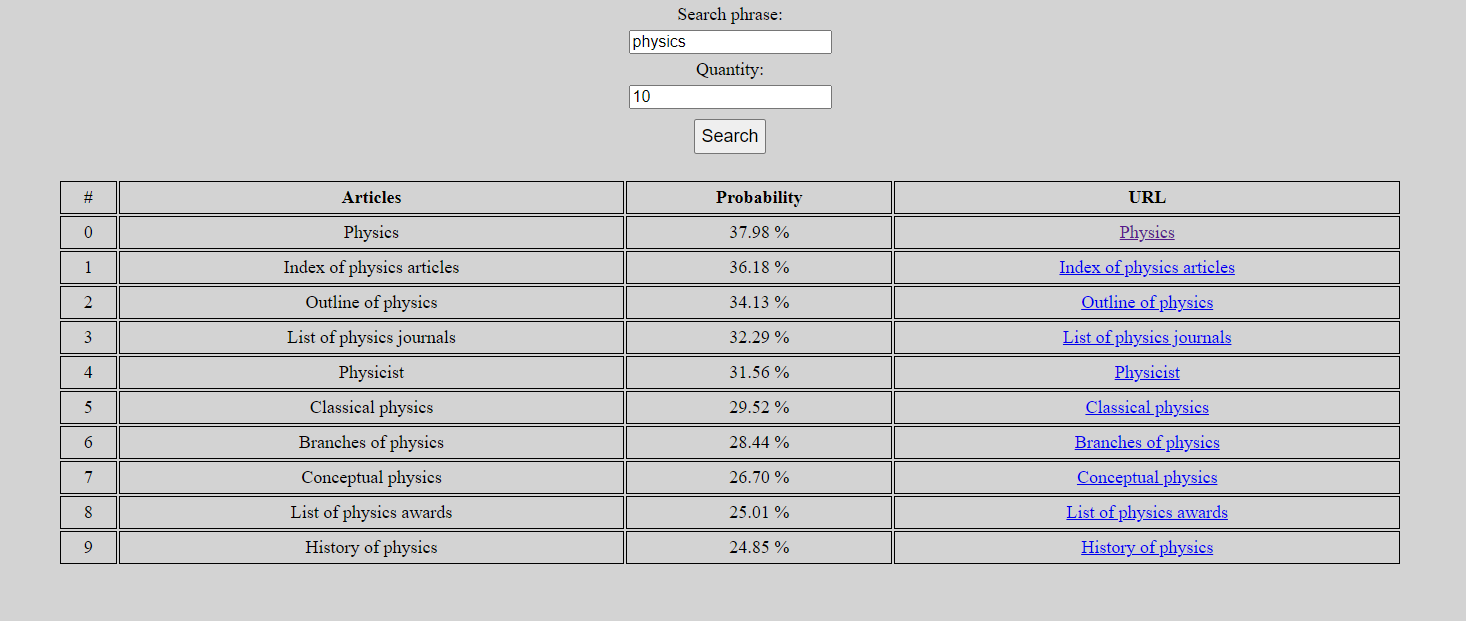

In [3]:
from IPython.display import Image
Image(filename='screens/example.png') 

Zastosowanie dla k = 300

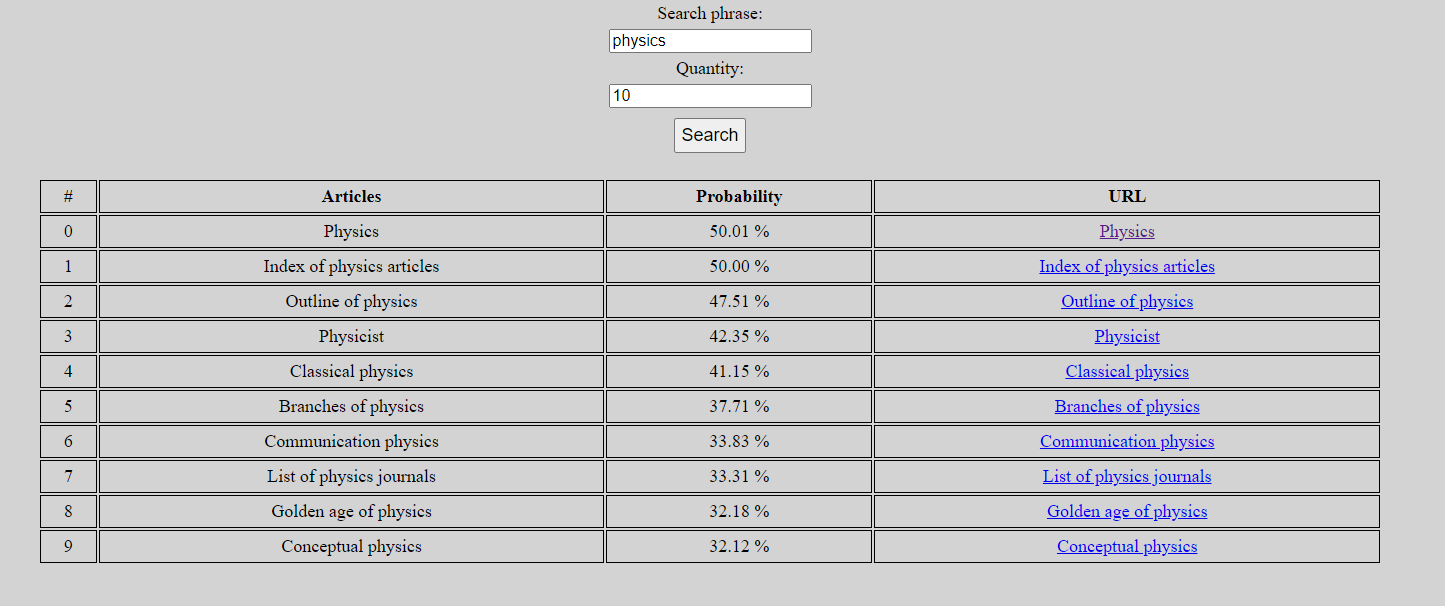

In [4]:
Image(filename='screens/example2.png') 

Program zdaje się działac poprawnie i nie wyświetla błędów, oczywiscie generowanie duzej ilosci artykułów wymaga czasu, skorzystałem z darmowej wersji google cloud computing aby móc wygenerować artykuły i stworzyć bag-of-words, równiez do tworzenia macierzy było to przydatne. 

W tym przypadku pobrałem 10 tysięcy artykułów, które są dość zróznicowane, kazde 500 artykułów pochodzi z innej kategori (łącznie 20 kategorii)

Uzycie svds w zasadzie zmniejszyło mi prawdopodobieństwa natomiast wydaje mi sie, po przeanalizowaniu, ze 
artykuly sa lepiej dobierane, a więc i lepsze wyniki, natomiast trzeba zgadnąć k.

Porównałem działanie programu dla k = 100 i dla k = 300 i wydaje się, ze lepiej wypada k = 300. Prawdopodobienstwo wzrosło w niektorych przypadkach nawet do 20 procent przy porównywaniu i wydaje się, ze miejscami lepiej znajduje przez to odpowiednie artykuły.

Wydaje mi się, ze tak maksymalna wartosc mogłabybyć w okolicach 1000, aczkolwiek wydaje mi sie ze nie zmieniłoby wiele az tak w porównaniu do k = 300


IDF nie mialo wiekszego znaczenia przy wyliczaniu 